<a href="https://colab.research.google.com/github/ShaswataJash/NLP/blob/master/KnowledgeGraphCreationExampleFromBioMedicalAbstract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Scientific spacy**

In [1]:
!pip install scispacy==0.2.5
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_core_sci_lg-0.2.5.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_ner_craft_md-0.2.5.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_ner_jnlpba_md-0.2.5.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_ner_bc5cdr_md-0.2.5.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_ner_bionlp13cg_md-0.2.5.tar.gz  

     |████████████████████████████████| 10.0MB 11.4MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 13.0MB 54.5MB/s 
     |████████████████████████████████| 2.1MB 44.1MB/s 
     |████████████████████████████████| 296kB 65.1MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 502.0MB 29kB/s 
  Created wheel for en-core-sci-lg: filename=en_core_sci_lg-0.2.5-cp36-none-any.whl size=502195831 sha256=14f0214671d96e8af931847d3b4b464ed8706a6324b36276ab9d8a4da7d135a5
  Stored in directory: /root/.cache/pip/wheels/76/9f/8f/1189c9f29507a2c67f53d890f2b12b78591f4bf42265fca777
Successfully built en-core-sci-lg
     |████████████████████████████████| 79.9MB 56kB/s 
  Created wheel for en-ner-craft-md: filename=en_ner_craft_md-0.2

**Install AllenNLP to access the neural-model for Coref resolution**

In [2]:
!pip install allennlp==1.1.0rc4 allennlp-models==1.1.0rc4

     |████████████████████████████████| 491kB 7.0MB/s 
     |████████████████████████████████| 327kB 19.9MB/s 
     |████████████████████████████████| 317kB 22.3MB/s 
     |████████████████████████████████| 778kB 27.8MB/s 
     |████████████████████████████████| 266kB 46.4MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 1.1MB 41.0MB/s 
     |████████████████████████████████| 3.0MB 53.9MB/s 
     |████████████████████████████████| 890kB 52.5MB/s 
  Created wheel for overrides: filename=overrides-3.1.0-cp36-none-any.whl size=10174 sha256=88c95d3f07a2966a42d4afc7011eb1088c37bcfa79665236b6f63c19fd87a1fe
  Stored in directory: /root/.cache/pip/wheels/5c/24/13/6ef8600e6f147c95e595f1289a86a3cc82ed65df57582c65a9
  Created wheel for jsonnet: filename=jsonnet-0.16.0-cp36-cp36m-linux_x86_64.whl size=3321609 sha256=74e5f542e76fdb9146ca3edb76fae1becf09cb97a708927857bbd510d7ba23b1
  Stored in dir

**If you want to try out hugginFace's neural-coref for coreference resolution, please execute following two notebook cells**

In [ ]:
!rm -Rf neuralcoref
!git clone https://github.com/huggingface/neuralcoref.git
!pip install ./neuralcoref

In [ ]:
!wget https://s3.amazonaws.com/models.huggingface.co/neuralcoref/neuralcoref.tar.gz ~/.neuralcoref_cache

--2020-08-22 15:20:01--  https://s3.amazonaws.com/models.huggingface.co/neuralcoref/neuralcoref.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.78.22
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.78.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40155833 (38M) [application/x-tar]
Saving to: ‘neuralcoref.tar.gz’

neuralcoref.tar.gz  100%[===================>]  38.29M  61.6MB/s    in 0.6s    

2020-08-22 15:20:01 (61.6 MB/s) - ‘neuralcoref.tar.gz’ saved [40155833/40155833]

/root/.neuralcoref_cache: Scheme missing.
FINISHED --2020-08-22 15:20:01--
Total wall clock time: 0.8s
Downloaded: 1 files, 38M in 0.6s (61.6 MB/s)


In [ ]:
!pip install gdown==3.6.4

**Please acquire UMLS license to download 2020AA UMLS Metathesaurus Files - 'MRCONSO.RRF' (refer: https://www.nlm.nih.gov/research/umls/licensedcontent/umlsknowledgesources.html)**

In [3]:
#downloading from my personal Google drive
import gdown
gdown.download('https://drive.google.com/uc?id=1dXYSVmb_R1-vvFORJXtbeHT1VQTjwrzM', 'umls-2020AA-mrconso.zip', quiet=False) #426MB

Downloading...
From: https://drive.google.com/uc?id=1dXYSVmb_R1-vvFORJXtbeHT1VQTjwrzM
To: /content/umls-2020AA-mrconso.zip
426MB [00:04, 89.9MB/s]


'umls-2020AA-mrconso.zip'

In [4]:
import shutil
import time
#ref: https://www.nlm.nih.gov/research/umls/licensedcontent/umlsknowledgesources.html

#unpacking of this zip file may take more than 30 seconds
start_time_of_unpacking = time.time()
shutil.unpack_archive('umls-2020AA-mrconso.zip', '.')
print("total time taken for unpacking = %s in seconds" % (time.time() - start_time_of_unpacking))

total time taken for unpacking = 18.65645956993103 in seconds


**Creating a token to CUI mapping from 'MRCONSO.RRF'**

In [5]:
from collections import defaultdict
import tqdm
import re

def myTokenizer(my_input, find_tokens_from_hyphenated_word=False):
    valid_tokens = set()
    tokens_with_hyphen = []

    text = re.sub(' +',' ',my_input) #without extra spaces
    text = text.replace (' -', '-') #convert to tight hyphen
    text = text.replace ('- ', '-') #convert to tight hyphen
    phrase = text.replace(',', ' ').replace(';', ' ') \
            .replace('(', '') \
            .replace(')', '') \
            .replace(':', '') \
            .replace('%', '') \
            .replace('{', '') \
            .replace('}', '') \
            .replace('[', '') \
            .replace(']', '') \
            .strip()
    tokens = phrase.split(' ') #first split token according to space
    if len(tokens) <= 1:
        if '-' in tokens[0]:
            tokens_with_hyphen.extend(tokens[0].split('-'))
        else:
            return None
    
    if len(tokens) > 1:
        for t in tokens:
            if len(t) <= 1:
                continue #single char tokens ignored e.g. %, blank tokens ignored (if consecutive multi spaces were present)
            try:
                float(t)
                continue #valid number including floating numbers are ignored
            except ValueError:
                valid_tokens.add(t)
                if '-' in t:
                    tokens_with_hyphen.extend(t.split('-'))

    if find_tokens_from_hyphenated_word:
        for t in tokens_with_hyphen:
            if len(t) <= 1:
                continue #single char tokens ignored e.g. %, blank tokens ignored (if consecutive multi spaces were present)
            try:
                float(t)
                continue #valid number including floating numbers are ignored
            except ValueError:
                valid_tokens.add(t)

    return valid_tokens


umls_header_columns = ['CUI','LAT','TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE', 'STR', 'SRL', 'SUPPRESS', 'CVF']

class UmlsMapper:

    def __init__(self, isCuiToLongNameMappingReqd=False):
        self.umls_dict = {}
        multi_token_to_cui_mapping = defaultdict(set)
        self.cui_to_minimal_text = {} 
        self.cui_to_maximal_text = {} 
         
        with open('MRCONSO.RRF', 'r', encoding='utf-8') as umls_file:
            for line in tqdm.tqdm(umls_file):
                umls_columns = line.split('|')
                lang = umls_columns[umls_header_columns.index('LAT')]
                if lang != 'ENG':
                    continue
                cui = umls_columns[umls_header_columns.index('CUI')]
                name = umls_columns[umls_header_columns.index('STR')].lower()
                self.umls_dict[name] = cui

                if cui in self.cui_to_minimal_text:
                    if len(name) < len(self.cui_to_minimal_text[cui]):
                        self.cui_to_minimal_text[cui] = name
                else:
                    self.cui_to_minimal_text[cui] = name

                if isCuiToLongNameMappingReqd:
                    if cui in self.cui_to_maximal_text:
                        if len(name) > len(self.cui_to_maximal_text[cui]):
                            self.cui_to_maximal_text[cui] = name
                    else:
                        self.cui_to_maximal_text[cui] = name

                #now check whether umls str is multi token
                multi_token = myTokenizer(name)
                if not (multi_token is None):
                    for token in multi_token:
                        multi_token_to_cui_mapping[token].add(cui)

        self.__umls_original_key_count = len(self.umls_dict)

        #now make a second pass to remove tokens which belonged to different CUI
        for token,cuis in multi_token_to_cui_mapping.items():
            if len(cuis) == 1:
                if not (token in self.umls_dict):
                    if token[0].isalnum() == False:
                        print(token,cuis)
                    self.umls_dict[token] = next(iter(cuis))

        del multi_token_to_cui_mapping

    def getOriginalKeysCount(self):
        return self.__umls_original_key_count
         
    def getKeysCount(self):
        return len(self.umls_dict)

    def getTokenToUmlsMapping(self, text, verbose=0):
        text = text.lower()
        try:
            return set([self.umls_dict[text]])
        except KeyError as e:
            if verbose > 0: print('getTokenToUmlsMapping(): <%s>' % (text))
            multi_token = myTokenizer(text)
            res = set()
            if not (multi_token is None):
                for token in multi_token:
                    try:
                        res.add(self.umls_dict[token])
                    except KeyError as e:
                        pass

            return res

    def getCUIToShortName(self,cui):
        try:
            return self.cui_to_minimal_text[cui]
        except KeyError as e:
            return ''

    def getCUIToLongName(self,cui):
        try:
            return self.cui_to_maximal_text[cui]
        except KeyError as e:
            return ''



In [6]:
umlsMapper = UmlsMapper()
print('getOriginalKeysCount=',umlsMapper.getOriginalKeysCount())
print('getKeysCount=',umlsMapper.getKeysCount())

15479756it [03:53, 66221.92it/s]


Streaming output truncated to the last 5000 lines.
#3353 {'C1574441'}
#3356 {'C1574442'}
#3705 {'C1574443'}
#3710 {'C1574444'}
#3213 {'C1574445'}
#3218 {'C1574446'}
#3223 {'C1574447'}
#3233 {'C1574448'}
#3110 {'C1574449'}
#3115 {'C1574450'}
#3120 {'C1574451'}
#46-401 {'C1574452'}
#46-402 {'C1574453'}
#2481 {'C1574492'}
#2494 {'C1574493'}
#2495 {'C1574494'}
#2981 {'C1574495'}
#2982 {'C1574496'}
#2983 {'C1574497'}
#2984 {'C1574498'}
#10800 {'C1574568'}
#4007 {'C1574569'}
#4654 {'C1574570'}
#4008 {'C1574571'}
#3031 {'C1574575'}
#7031 {'C1574576'}
#7203 {'C1574578'}
#3042 {'C1574579'}
#7042 {'C1574580'}
#7842 {'C1574581'}
#7048 {'C1574582'}
#5335 {'C1574583'}
#5033 {'C1574584'}
#5833 {'C1574585'}
#5124 {'C1574586'}
#7412 {'C1574587'}
#5244 {'C1574588'}
#5044 {'C1574589'}
#0405 {'C1574590'}
#7405 {'C1574591'}
#5055 {'C1574592'}
#5855 {'C1574593'}
#5077 {'C1574594'}
#0606 {'C1574595'}
#900010 {'C1574650'}
#900070 {'C1574651'}
#900030 {'C1574652'}
#900020 {'C1574653'}
#900040 {'C1574654'}
#90

**Few sample abstracts of BioMedical scientific papers** 

In [7]:
import pprint
t1 = 'Inflammatory diseases of the respiratory tract are commonly associated with elevated production of nitric oxide (NOâ€¢) and increased indices of NOâ€¢ -dependent oxidative stress. Although NOâ€¢ is known to have anti-microbial, anti-inflammatory and anti-oxidant properties, various lines of evidence support the contribution of NOâ€¢ to lung injury in several disease models. On the basis of biochemical evidence, it is often presumed that such NOâ€¢ -dependent oxidations are due to the formation of the oxidant peroxynitrite, although alternative mechanisms involving the phagocyte-derived heme proteins myeloperoxidase and eosinophil peroxidase might be operative during conditions of inflammation. Because of the overwhelming literature on NOâ€¢ generation and activities in the respiratory tract, it would be beyond the scope of this commentary to review this area comprehensively. Instead, it focuses on recent evidence and concepts of the presumed contribution of NOâ€¢ to inflammatory diseases of the lung.'.encode('cp1252').decode('utf-8')
pprint.pprint(t1, width=120)
t2 = 'Heterogeneous nuclear ribonucleoprotein (hnRNP A1) is involved in pre-mRNA splicing in the nucleus and translational regulation in the cytoplasm. In the present study, we demonstrate that hnRNP A1 also participates in the transcription and replication of a cytoplasmic RNA virus, mouse hepatitis virus (MHV). Overexpression of hnRNP A1 accelerated the kinetics of viral RNA synthesis, whereas the expression in the cytoplasm of a dominant-negative hnRNP A1 mutant that lacks the nuclear transport domain significantly delayed it. The hnRNP A1 mutant caused a global inhibition of viral mRNA transcription and genomic replication, and also a preferential inhibition of the replication of defective-interfering RNAs. Similar to the wild-type hnRNP A1, the hnRNP A1 mutant complexed with an MHV polymerase gene product, the nucleocapsid protein and the viral RNA. However, in contrast to the wild-type hnRNP A1, the mutant protein failed to bind a 250 kDa cellular protein, suggesting that the recruitment of cellular proteins by hnRNP A1 is important for MHV RNA synthesis. Our findings establish the importance of cellular factors in viral RNA-dependent RNA synthesis.'.encode('cp1252').decode('utf-8')
pprint.pprint(t2, width=120)
t3 = 'Recent evidence suggests that critically ill patients are able to tolerate lower levels of haemoglobin than was previously believed. It is our goal to show that transfusing to a level of 100 g/l does not improve mortality and other clinically important outcomes in a critical care setting. Although many questions remain, many laboratory and clinical studies, including a recent randomized controlled trial (RCT), have established that transfusing to normal haemoglobin concentrations does not improve organ failure and mortality in the critically ill patient. In addition, a restrictive transfusion strategy will reduce exposure to allogeneic transfusions, result in more efficient use of red blood cells (RBCs), save blood overall, and decrease health care costs.'.encode('cp1252').decode('utf-8')
pprint.pprint(t3, width=120)

('Inflammatory diseases of the respiratory tract are commonly associated with elevated production of nitric oxide '
 '(NO•) and increased indices of NO• -dependent oxidative stress. Although NO• is known to have anti-microbial, '
 'anti-inflammatory and anti-oxidant properties, various lines of evidence support the contribution of NO• to lung '
 'injury in several disease models. On the basis of biochemical evidence, it is often presumed that such NO• '
 '-dependent oxidations are due to the formation of the oxidant peroxynitrite, although alternative mechanisms '
 'involving the phagocyte-derived heme proteins myeloperoxidase and eosinophil peroxidase might be operative during '
 'conditions of inflammation. Because of the overwhelming literature on NO• generation and activities in the '
 'respiratory tract, it would be beyond the scope of this commentary to review this area comprehensively. Instead, it '
 'focuses on recent evidence and concepts of the presumed contribution of NO• to

*   Two different ways of Abbreviation resolver
*   Two different ways of Coreference resolution

In [9]:
import re

def cleanTexts(original_text):
    text = original_text
    text = re.sub(' +',' ',text) #without extra spaces
    #Note hyphens which are placed tightly between two words (i.e. without any space) are fine
    text = text.replace (' -', '-') #remove extra space before hyphen
    text = text.replace ('- ', '-') #remove extra space after hyphen 
    return text    

#Much faster implementation than scispacy's AbbreviationDetector
#Additionally, scispacy does not able to correctly resolve abbreviation for (hnRNP A1) in t2
def myResolvedAbbreviation(original_text, verbose=0):
    current_state = 0
    abbr_map = {}
    token_list = []
    current_token = ''
    for c in original_text:
        if current_state == 0:
            if c == '(':
                if len(current_token) > 0:
                    token_list.append(current_token)
                current_token = ''
                current_state = 1
            elif c.isspace():
                if len(current_token) > 0:
                    token_list.append(current_token.lower())
                current_token = ''
            else:
                current_token += c

        elif  current_state == 1:
            if c == ')':
                current_token = current_token.strip()
                assert len(current_token) > 0
                abbr_original = current_token
                abbr = current_token.lower()
                first_char_in_abbr = abbr[0]
                count_of_first_char = abbr.count(first_char_in_abbr)
                first_char_observed = 0
                abbr_resolved = []
                for t in reversed(token_list):
                    abbr_resolved.append(t)
                    if t[0] == first_char_in_abbr:
                        first_char_observed += 1
                        if first_char_observed == count_of_first_char:
                            abbr_map[abbr_original] = ' '.join(reversed(abbr_resolved))
                            if verbose>0:
                                print(abbr_original,abbr_map[abbr_original])
                            break
                token_list.clear()
                current_state = 0
            else:
                current_token += c

    abrreviatedReplacedText = original_text
    for abrv,abrv_resolved in abbr_map.items():
        abrreviatedReplacedText = abrreviatedReplacedText.replace(abrv, '', 1) #remove first occurence of abbreviation
        abrreviatedReplacedText = abrreviatedReplacedText.replace('()','')
        abrreviatedReplacedText = abrreviatedReplacedText.replace(abrv,abrv_resolved)
    return abrreviatedReplacedText


def resolveAbbreviation(original_text, verbose=0):
    from scispacy.abbreviation import AbbreviationDetector
    import en_core_sci_lg

    nlp = en_core_sci_lg.load() #refer: https://allenai.github.io/scispacy/
    
    # Add the abbreviation pipe to the spacy pipeline.
    abbreviation_pipe = AbbreviationDetector(nlp)
    nlp.add_pipe(abbreviation_pipe)

    doc = nlp(original_text)
    abbrMap = {}
    abrreviatedReplacedText = original_text
    for abrv in doc._.abbreviations:
        if str(abrv) not in abbrMap:
            abbrMap[str(abrv)] = str(abrv._.long_form)
            if verbose >= 1:
                print("Abbr found=%s %s" % (str(abrv),str(abrv._.long_form)))
            abrreviatedReplacedText = abrreviatedReplacedText.replace(str(abrv), '', 1) #remove first occurence of abbreviation
            abrreviatedReplacedText = abrreviatedReplacedText.replace('()','')
            abrreviatedReplacedText = abrreviatedReplacedText.replace(str(abrv),str(abrv._.long_form))
        else:
            assert abbrMap[str(abrv)] == str(abrv._.long_form)
    return abrreviatedReplacedText

#AllenNLP models does correct coref resolution for 't2'
def resolvePronounCorefUsingAllenNLP(original_text, verbose=0):
    from allennlp.predictors.predictor import Predictor
    import allennlp_models.coref
    predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2020.02.27.tar.gz")
    result = predictor.predict(document=original_text)
    
    coref_map = {}
    for cluster in result['clusters']:
        main_group_extracted = ''
        for group in cluster:
            assert len(group) == 2
            start_token_of_group = group[0]
            end_token_of_group = group[-1]
            if main_group_extracted == '':
                for t in range(start_token_of_group,end_token_of_group+1):
                    main_group_extracted = main_group_extracted + result['document'][t] + ' '
                if verbose > 0:print(main_group_extracted)
            else:
                if (end_token_of_group - start_token_of_group) == 0:
                    coref_map[start_token_of_group] = main_group_extracted
                    if verbose > 0:print(result['document'][start_token_of_group], start_token_of_group, '=>', main_group_extracted.strip())

    coref_resolved_text = ''
    for token_index,token in enumerate(result['document']):
        if token_index in coref_map:
            coref_resolved_text = coref_resolved_text + coref_map[token_index] + ' '
        else:
            coref_resolved_text = coref_resolved_text + token + ' '

    return coref_resolved_text

def resolvePronounCorefUsingNeuralCoref(original_text, greedyness=0.5):
    import neuralcoref
    import en_core_sci_lg

    nlp = en_core_sci_lg.load()
    #add coreference resolver in pipeline
    coref = neuralcoref.NeuralCoref(nlp.vocab, greedyness=greedyness)
    nlp.add_pipe(coref, name='neuralcoref')
    doc = nlp(original_text)
    #https://www.rangakrish.com/index.php/2019/02/03/coreference-resolution-using-spacy/
    for token in doc:
        if token.pos_ == 'PRON' and token._.in_coref:
            for cluster in token._.coref_clusters:
                print(token.text + ' => ' + cluster.main.text)
    return doc._.coref_resolved #co-reference resolved (pronoun resolved with target noun)

cleanedText = cleanTexts(t3)
#abrreviatedReplacedText = resolveAbbreviation(cleanedText, verbose=1)
abrreviatedReplacedText = myResolvedAbbreviation(cleanedText, verbose=1)
pprint.pprint("abbr  resolved text=\n%s" % (abrreviatedReplacedText),  width=120)
#corefResolvedText = resolvePronounCorefUsingNeuralCoref(abrreviatedReplacedText)
corefResolvedText = resolvePronounCorefUsingAllenNLP(abrreviatedReplacedText, verbose=1)
pprint.pprint("coref resolved text=\n%s" % (corefResolvedText), width=120)


RCT randomized controlled trial
RBCs red blood cells
('abbr  resolved text=\n'
 'Recent evidence suggests that critically ill patients are able to tolerate lower levels of haemoglobin than was '
 'previously believed. It is our goal to show that transfusing to a level of 100 g/l does not improve mortality and '
 'other clinically important outcomes in a critical care setting. Although many questions remain, many laboratory and '
 'clinical studies, including a recent randomized controlled trial , have established that transfusing to normal '
 'haemoglobin concentrations does not improve organ failure and mortality in the critically ill patient. In addition, '
 'a restrictive transfusion strategy will reduce exposure to allogeneic transfusions, result in more efficient use of '
 'red blood cells , save blood overall, and decrease health care costs.')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package 

downloading: 100%|##########| 1345947288/1345947288 [00:28<00:00, 47421536.99B/s]


Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Did not use initialization regex that was passed: _context_layer._module.weight_hh.*
Did not use initialization regex that was passed: _context_layer._module.weight_ih.*
/usr/local/lib/python3.6/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


('coref resolved text=\n'
 'Recent evidence suggests that critically ill patients are able to tolerate lower levels of haemoglobin than was '
 'previously believed . It is our goal to show that transfusing to a level of 100 g / l does not improve mortality and '
 'other clinically important outcomes in a critical care setting . Although many questions remain , many laboratory '
 'and clinical studies , including a recent randomized controlled trial , have established that transfusing to normal '
 'haemoglobin concentrations does not improve organ failure and mortality in the critically ill patient . In addition '
 ', a restrictive transfusion strategy will reduce exposure to allogeneic transfusions , result in more efficient use '
 'of red blood cells , save blood overall , and decrease health care costs . ')


**Class holding end-to-end NLP pipeline logic for extracting concepts and relationship tuple between them.**

In [17]:
import spacy
from spacy import displacy
import en_core_sci_lg
import en_ner_craft_md #GGP, SO, TAXON, CHEBI, GO, CL
import en_ner_jnlpba_md #DNA, CELL_TYPE, CELL_LINE, RNA, PROTEIN
import en_ner_bc5cdr_md #DISEASE, CHEMICAL
import en_ner_bionlp13cg_md #CANCER, ORGAN, TISSUE, ORGANISM, CELL, AMINO_ACID, GENE_OR_GENE_PRODUCT, SIMPLE_CHEMICAL, ANATOMICAL_SYSTEM, IMMATERIAL_ANATOMICAL_ENTITY, MULTI-TISSUE_STRUCTURE, DEVELOPING_ANATOMICAL_STRUCTURE, ORGANISM_SUBDIVISION, CELLULAR_COMPONENT

from allennlp.predictors.predictor import Predictor

import re
from collections import defaultdict
from tabulate import tabulate
import pprint
import itertools

class NERRelationshipExtraction:

    def __init__(self):
    
        self.__predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2020.02.27.tar.gz")

        self.__nlp_en_ner_craft_md = en_ner_craft_md.load()
        self.__nlp_en_ner_jnlpba_md = en_ner_jnlpba_md.load()
        self.__nlp_en_ner_bc5cdr_md = en_ner_bc5cdr_md.load()
        self.__nlp_en_ner_bionlp13cg_md = en_ner_bionlp13cg_md.load()
        self.__nlp_en_core_sci_lg = en_core_sci_lg.load()

        self.__nlp_en_ner_craft_md.add_pipe(self.__nlp_en_ner_craft_md.create_pipe("merge_entities"))
        self.__nlp_en_ner_jnlpba_md.add_pipe(self.__nlp_en_ner_jnlpba_md.create_pipe("merge_entities"))
        self.__nlp_en_ner_bc5cdr_md.add_pipe(self.__nlp_en_ner_bc5cdr_md.create_pipe("merge_entities"))
        self.__nlp_en_ner_bionlp13cg_md.add_pipe(self.__nlp_en_ner_bionlp13cg_md.create_pipe("merge_entities"))
        self.__nlp_en_core_sci_lg.add_pipe(self.__nlp_en_core_sci_lg.create_pipe("merge_entities"))

    @staticmethod
    def __cleanTexts(original_text):
        text = original_text
        text = re.sub(' +',' ',text) #without extra spaces
        #Note hyphens which are placed tightly between two words (i.e. without any space) are fine
        text = text.replace (' -', '-') #remove extra space before hyphen
        text = text.replace ('- ', '-') #remove extra space after hyphen 
        return text    

    @staticmethod
    def __myResolvedAbbreviation(original_text, verbose=0):
        current_state = 0
        abbr_map = {}
        token_list = []
        current_token = ''
        for c in original_text:
            if current_state == 0:
                if c == '(':
                    if len(current_token) > 0:
                        token_list.append(current_token)
                    current_token = ''
                    current_state = 1
                elif c.isspace():
                    if len(current_token) > 0:
                        token_list.append(current_token.lower())
                    current_token = ''
                else:
                    current_token += c

            elif  current_state == 1:
                if c == ')':
                    current_token = current_token.strip()
                    assert len(current_token) > 0
                    abbr_original = current_token
                    abbr = current_token.lower()
                    first_char_in_abbr = abbr[0]
                    count_of_first_char = abbr.count(first_char_in_abbr)
                    first_char_observed = 0
                    abbr_resolved = []
                    for t in reversed(token_list):
                        abbr_resolved.append(t)
                        if t[0] == first_char_in_abbr:
                            first_char_observed += 1
                            if first_char_observed == count_of_first_char:
                                abbr_map[abbr_original] = ' '.join(reversed(abbr_resolved))
                                if verbose>0:print(abbr_original,abbr_map[abbr_original])
                                break
                    token_list.clear()
                    current_state = 0
                else:
                    current_token += c

        abrreviatedReplacedText = original_text
        for abrv,abrv_resolved in abbr_map.items():
            abrreviatedReplacedText = abrreviatedReplacedText.replace(abrv, '', 1) #remove first occurence of abbreviation
            abrreviatedReplacedText = abrreviatedReplacedText.replace('()','')
            abrreviatedReplacedText = abrreviatedReplacedText.replace(abrv,abrv_resolved)
        return abrreviatedReplacedText

    def __resolvePronounCorefUsingAllenNLP(self, original_text, verbose=0):
    
        result = self.__predictor.predict(document=original_text)
    
        coref_map = {}
        for cluster in result['clusters']:
            main_group_extracted = ''
            for group in cluster:
                assert len(group) == 2
                start_token_of_group = group[0]
                end_token_of_group = group[-1]
                if main_group_extracted == '':
                    for t in range(start_token_of_group,end_token_of_group+1):
                        main_group_extracted = main_group_extracted + result['document'][t] + ' '
                    if verbose > 0:print(main_group_extracted)
                else:
                    if (end_token_of_group - start_token_of_group) == 0:
                        coref_map[start_token_of_group] = main_group_extracted
                        if verbose > 0:print(result['document'][start_token_of_group], start_token_of_group, '=>', main_group_extracted.strip())

        coref_resolved_text = ''
        for token_index,token in enumerate(result['document']):
            if token_index in coref_map:
                coref_resolved_text = coref_resolved_text + coref_map[token_index] + ' '
            else:
                coref_resolved_text = coref_resolved_text + token + ' '

        return coref_resolved_text
    
    @staticmethod
    def __extract_entities(doc, umlsMapper, toRender):
        if toRender:
            displacy.render(doc, jupyter=True,style='ent')
            for s in doc.sents:
                displacy.render(s, jupyter=True,style='dep')
        ent_count = defaultdict(int)
        sent_to_ent = []
    
        for s in doc.sents:
            noun_in_current_sent = set()
            sent_to_token_detailed_info = []
            for token in s:
                if toRender:
                    sent_to_token_detailed_info.append([token.text, token.lemma_, token.pos_, token.tag_, token.dep_])
                if token.pos_ == 'NOUN':
                    noun_in_current_sent.add(token.text.lower().strip())
            if toRender:
                table = tabulate(sent_to_token_detailed_info, headers=['text', 'lemma', 'pos', 'tag', 'dep'], tablefmt='orgtbl')
                print(table)

            ent_in_current_sent = set()
            for X in s.ents:
                entityInLowerCase = X.text.lower().strip()
                if entityInLowerCase in noun_in_current_sent:
                    entToCUIMapped = umlsMapper.getTokenToUmlsMapping(entityInLowerCase)
                    if len(entToCUIMapped) >= 1:
                        for c in entToCUIMapped:
                            ent_count[c] += 1
                            ent_in_current_sent.add(c)
                    else: #no appropriate mapping in UMLS
                        ent_count[entityInLowerCase] += 1
                        ent_in_current_sent.add(entityInLowerCase)

            if len(ent_in_current_sent) > 1:
                sent_to_ent.append(ent_in_current_sent)
        
        return ent_count,sent_to_ent

    def getEntityAndEntRelationshipByApplyingAllModels(self, texts_map, umlsMapper, toRender=False, verbosity=0):

        texts = []
        docids = []
        for docid,root_text in texts_map.items():
            cleanedText = NERRelationshipExtraction.__cleanTexts(root_text)
            abrreviatedReplacedText = NERRelationshipExtraction.__myResolvedAbbreviation(cleanedText, verbose=verbosity)
            if verbosity> 0: pprint.pprint("Doc-id=%s abbr  resolved text=\n%s" % (docid,abrreviatedReplacedText),  width=120)
            corefResolvedText = self.__resolvePronounCorefUsingAllenNLP(abrreviatedReplacedText, verbose=verbosity)
            if verbosity> 0: pprint.pprint("Doc-id=%s coref resolved text=\n%s" % (docid,corefResolvedText), width=120)
            texts.append(corefResolvedText)
            docids.append(docid)

        docid_to_ent_info_map = defaultdict(dict)
        for docid,doc in zip(docids,self.__nlp_en_ner_craft_md.pipe(texts)):
            craft_md_entities_count, craft_md_sent_to_ent = NERRelationshipExtraction.__extract_entities(doc,umlsMapper,toRender)
            if verbosity > 0:
                print("Doc-id=",docid,"craft_md Entity count:",pprint.pformat(craft_md_entities_count))
                print("Doc-id=",docid,"craft_md Sent to ent map:",pprint.pformat(craft_md_sent_to_ent))
            docid_to_ent_info_map[docid]['craft_md_entities_count'] = craft_md_entities_count
            docid_to_ent_info_map[docid]['craft_md_sent_to_ent'] = craft_md_sent_to_ent

        for docid,doc in zip(docids,self.__nlp_en_ner_jnlpba_md.pipe(texts)):
            jnlpba_md_entities_count, jnlpba_md_sent_to_ent = NERRelationshipExtraction.__extract_entities(doc,umlsMapper,toRender)
            if verbosity > 0:
                print("Doc-id=",docid,"jnlpba_mdEntity count:",pprint.pformat(jnlpba_md_entities_count))
                print("Doc-id=",docid,"jnlpba_md Sent to ent map:",pprint.pformat(jnlpba_md_sent_to_ent))
            docid_to_ent_info_map[docid]['jnlpba_md_entities_count'] = jnlpba_md_entities_count
            docid_to_ent_info_map[docid]['jnlpba_md_sent_to_ent'] = jnlpba_md_sent_to_ent

        for docid,doc in zip(docids,self.__nlp_en_ner_bc5cdr_md.pipe(texts)):
            bc5cdr_md_entities_count, bc5cdr_md_sent_to_ent = NERRelationshipExtraction.__extract_entities(doc,umlsMapper,toRender)
            if verbosity > 0:
                print("Doc-id=",docid,"bc5cdr_md Entity count:",pprint.pformat(bc5cdr_md_entities_count))
                print("Doc-id=",docid,"bc5cdr_md Sent to ent map:",pprint.pformat(bc5cdr_md_sent_to_ent))
            docid_to_ent_info_map[docid]['bc5cdr_md_entities_count'] = bc5cdr_md_entities_count
            docid_to_ent_info_map[docid]['bc5cdr_md_sent_to_ent'] = bc5cdr_md_sent_to_ent

        for docid,doc in zip(docids,self.__nlp_en_ner_bionlp13cg_md.pipe(texts)):
            bionlp13cg_md_entities_count, bionlp13cg_md_sent_to_ent = NERRelationshipExtraction.__extract_entities(doc,umlsMapper,toRender)
            if verbosity > 0:
                print("Doc-id=",docid,"bionlp13cg_md Entity count:",pprint.pformat(bionlp13cg_md_entities_count))
                print("Doc-id=",docid,"bionlp13cg_md Sent to ent map:",pprint.pformat(bionlp13cg_md_sent_to_ent))
            docid_to_ent_info_map[docid]['bionlp13cg_md_entities_count'] = bionlp13cg_md_entities_count
            docid_to_ent_info_map[docid]['bionlp13cg_md_sent_to_ent'] = bionlp13cg_md_sent_to_ent

        for docid,doc in zip(docids,self.__nlp_en_core_sci_lg.pipe(texts)):
            core_sci_lg_entities_count, core_sci_lg_sent_to_ent = NERRelationshipExtraction.__extract_entities(doc,umlsMapper,toRender)
            if verbosity > 0:
                print("Doc-id=",docid,"core_sci_lg Entity count:",pprint.pformat(core_sci_lg_entities_count))
                print("Doc-id=",docid,"core_sci_lg Sent to ent map:",pprint.pformat(core_sci_lg_sent_to_ent))
            docid_to_ent_info_map[docid]['core_sci_lg_entities_count'] = core_sci_lg_entities_count
            docid_to_ent_info_map[docid]['core_sci_lg_sent_to_ent'] = core_sci_lg_sent_to_ent

        #combine the different entities
        docid_to_entity_count_map = {} #map of maps
        for docid,ent_info_in_doc in docid_to_ent_info_map.items():
            combined_entity_count = {}
            for d in [ent_info_in_doc['core_sci_lg_entities_count'],
                      ent_info_in_doc['bionlp13cg_md_entities_count'],
                      ent_info_in_doc['bc5cdr_md_entities_count'],
                      ent_info_in_doc['jnlpba_md_entities_count'],
                      ent_info_in_doc['craft_md_entities_count']]:
                for k in d.keys():
                    if k in combined_entity_count and d[k] > combined_entity_count[k] :
                        combined_entity_count[k] = d[k]
                    else:
                        combined_entity_count[k] = d[k]

            if verbosity>0:
                print("Doc-id=",docid,"combined all model Entity count:")
                for ent,count in combined_entity_count.items():
                    print(ent,'<',umlsMapper.getCUIToShortName(ent),'><',umlsMapper.getCUIToLongName(ent),'> :', count)

            docid_to_entity_count_map[docid] = combined_entity_count

        #combine the different ent per sentense
        docid_to_sent_to_ent_map = {} #map of maps
        for docid,ent_info_in_doc in docid_to_ent_info_map.items():
            combined_sent_to_ent_relationship = defaultdict(int)
            for d in [ent_info_in_doc['core_sci_lg_sent_to_ent'],
                      ent_info_in_doc['bionlp13cg_md_sent_to_ent'],
                      ent_info_in_doc['bc5cdr_md_sent_to_ent'],
                      ent_info_in_doc['jnlpba_md_sent_to_ent'],
                      ent_info_in_doc['craft_md_sent_to_ent']]:
                for s_to_ent in d:
                    #we are sorting the s_to_ent set, so that combination tuple are also generated in ordered fashion
                    #this will ensure same tuples (but unordered) will not be inserted as different key in combined_sent_to_ent_relationship
                    all_possible_bituple = list(itertools.combinations(sorted(s_to_ent), 2)) 
                    for p in all_possible_bituple:
                        combined_sent_to_ent_relationship[p] += 1

            if verbosity>0:
                print("Doc-id=",docid,"combined all model Entity relationship tuple count:")
                for ent_tuple,count in combined_sent_to_ent_relationship.items():
                    print(ent_tuple[0],'<',umlsMapper.getCUIToShortName(ent_tuple[0]),'> - ', ent_tuple[1], '<', umlsMapper.getCUIToShortName(ent_tuple[1]),'> :', count)

            docid_to_sent_to_ent_map[docid] = combined_sent_to_ent_relationship

        return docid_to_entity_count_map, docid_to_sent_to_ent_map




In [18]:
import gc

if 'nerRelExtract' in globals():
    del nerRelExtract
gc.collect()

nerRelExtract = NERRelationshipExtraction()
texts_map = {
    1:t1,
    2:t2,
    3:t3
}
docid_to_entity_count_map, docid_to_sent_to_ent_map = nerRelExtract.getEntityAndEntRelationshipByApplyingAllModels(texts_map, umlsMapper)

global_combined_ent_count = defaultdict(int)
for docid,ent_info_in_doc in docid_to_entity_count_map.items():
    for ent,count in ent_info_in_doc.items():
        global_combined_ent_count[ent] += count

for ent,count in global_combined_ent_count.items():
    print(ent,'<',umlsMapper.getCUIToShortName(ent),'><',umlsMapper.getCUIToLongName(ent),'> :', count)

print("==========================================")

global_combined_ent_rel_tuple_count = defaultdict(int)
for docid,ent_info_in_doc in docid_to_sent_to_ent_map.items():
    for ent_tuple,count in ent_info_in_doc.items():
        global_combined_ent_rel_tuple_count[ent_tuple] += count

for ent_tuple,count in global_combined_ent_rel_tuple_count.items():
    print(ent_tuple[0],'<',umlsMapper.getCUIToShortName(ent_tuple[0]),'> - ', ent_tuple[1], '<', umlsMapper.getCUIToShortName(ent_tuple[1]),'> :', count)

C0012634 < dis ><  > : 2
C0333348 < inflam ><  > : 2
C1283798 < respiratory tract ><  > : 2
C1548180 < production ><  > : 1
C3810607 < no ><  > : 5
C4033634 < indices ><  > : 1
C1292721 < properties ><  > : 1
C3887511 < evidence ><  > : 4
C1880177 < contribute ><  > : 2
C0273115 < lung injury ><  > : 1
C0684309 < disease model ><  > : 1
C0030011 < oxidize ><  > : 1
C1522492 < form ><  > : 1
C0136157 < peroxynitrite ><  > : 1
C0441712 < mechanism ><  > : 1
C0031307 < phagocyte ><  > : 1
C2698399 < mpo ><  > : 1
C1414438 < epp ><  > : 1
conditions <  ><  > : 1
C0021368 < inflamm ><  > : 1
C0034036 < literature ><  > : 1
C2239122 < activities ><  > : 1
C1510751 < area ><  > : 1
C0178566 < concept ><  > : 1
C1278908 < lung ><  > : 2
C0033684 < protein ><  > : 2
C0018966 < hem ><  > : 1
C0085403 < oxidant ><  > : 1
C0018974 < hemeprotein ><  > : 1
C1325334 < hnrnp ><  > : 3
C0035696 < mrna ><  > : 1
C2610186 < splicing ><  > : 1
C4724279 < nucleus ><  > : 1
C3537096 < translation alteration

**Just for demonstration - mapping tuples representing related UMLS concept appearing as part of same sentense on network-graph**

In [19]:
!pip install networkx==2.5

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
print("doc count=", len(docid_to_sent_to_ent_map))
for docid, combined_sent_to_ent_relationship in docid_to_sent_to_ent_map.items():
    for ed_tuple,count in combined_sent_to_ent_relationship.items():
        G.add_edge(ed_tuple[0], ed_tuple[1], weight = count)

doc count= 3


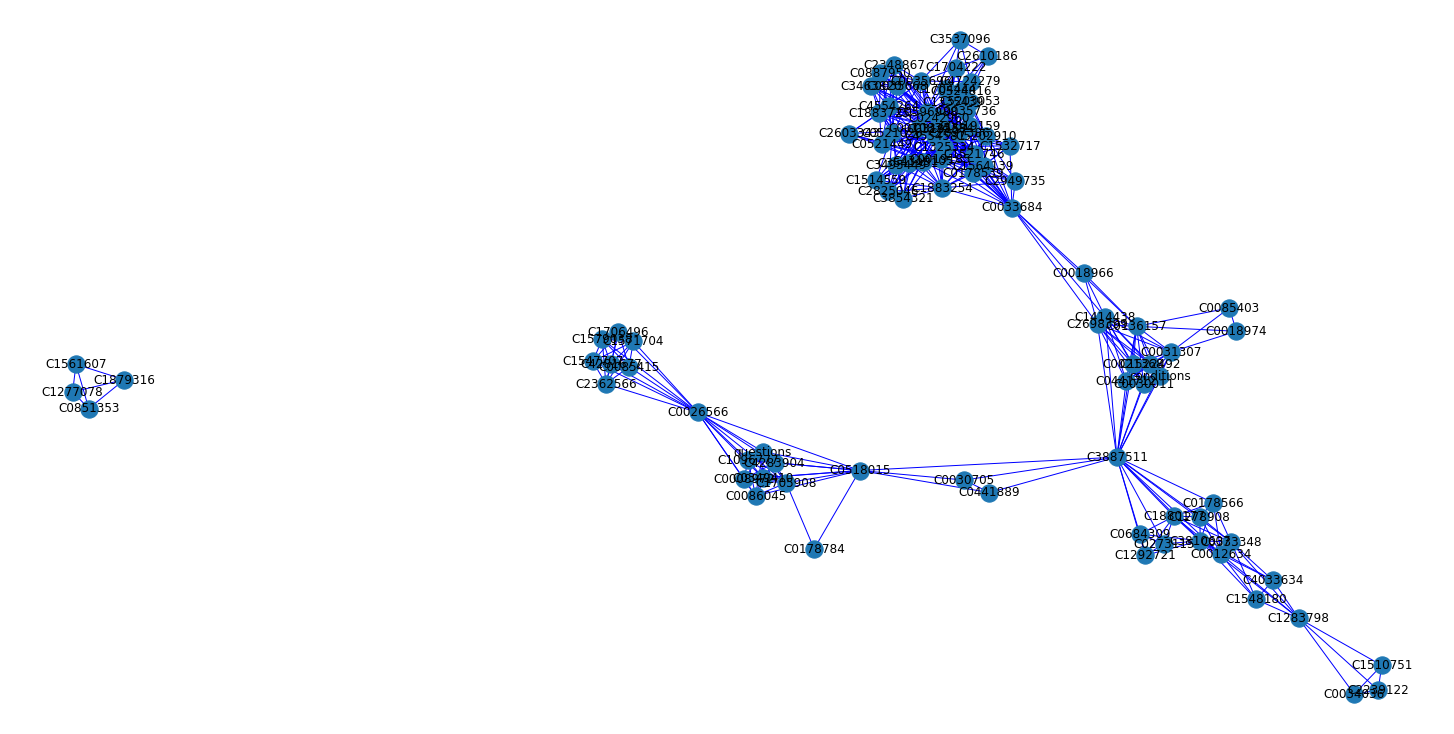

In [25]:
plt.figure(figsize=(20,10))
#nx.draw(G, pos=nx.circular_layout(G), edge_color='b', with_labels=True)
nx.draw(G, edge_color='b', with_labels=True)